In [1]:
# Extract features from the mask image
# Cell type
#0. background
#1. neoplastic
#2. inflammatory
#3. soft tissue
#4. dead
#5. epithelial

In [2]:
import math
import numpy as np
import skimage
import matplotlib.pyplot as plt
import histomicstk as htk
import matplotlib.patches as mpatches

In [3]:
# Set source files
source_dir = '/mnt/storage2/PanNuke/fold1/'
tissue_dir = 'Breast/'
images = source_dir+tissue_dir+'images/img_Breast_1_00000.png'
# masks = source_dir+tissue_dir+'sem_masks/sem_Breast_1_00000.png'
masks = '/home/slee297/sem_masks/test.png'

In [4]:
# Read images
raw_image = skimage.io.imread(images)
raw_mask = skimage.io.imread(masks)

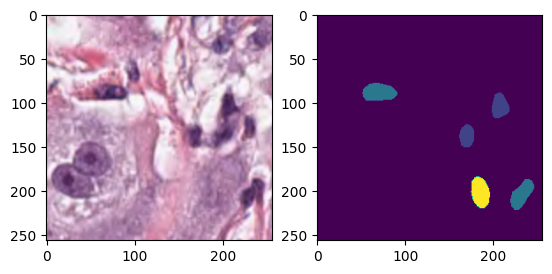

In [5]:
# Confirm original images
fig, ax = plt.subplots(1, 2)
ax[0].imshow(raw_image)
ax[1].imshow(raw_mask)

In [6]:
# Perform color normalization
ref_image_file = ('https://data.kitware.com/api/v1/file/'
                  '57718cc28d777f1ecd8a883c/download')  # L1.png
im_reference = skimage.io.imread(ref_image_file)[:, :, :3]
mean_ref, std_ref = htk.preprocessing.color_conversion.lab_mean_std(im_reference)
im_nmzd = htk.preprocessing.color_normalization.reinhard(raw_image, mean_ref, std_ref)

In [7]:
# Perform color deconvolution
# create stain to color map
stainColorMap = {
    'hematoxylin': [0.65, 0.70, 0.29],
    'eosin':       [0.07, 0.99, 0.11],
    'dab':         [0.27, 0.57, 0.78],
    'null':        [0.0, 0.0, 0.0],
}

# specify stains of input image
stain_1 = 'hematoxylin'   # nuclei stain
stain_2 = 'eosin'         # cytoplasm stain
stain_3 = 'null'          # set to null of input contains only two stains

# create stain matrix
W = np.array([stainColorMap[stain_1],
              stainColorMap[stain_2],
              stainColorMap[stain_3]]).T

# perform standard color deconvolution
im_stains = htk.preprocessing.color_deconvolution.color_deconvolution(im_nmzd, W).Stains
im_intensity = im_stains[:, :, 0]

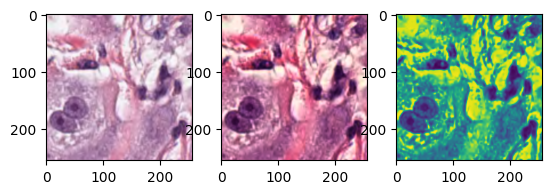

In [8]:
# Confirm original, normalized, and deconvolved images
fig, ax = plt.subplots(1, 3)
ax[0].imshow(raw_image)
ax[1].imshow(im_nmzd)
ax[2].imshow(im_intensity)

In [9]:
# Change to labels
im_label = skimage.measure.label(raw_mask)

In [10]:
# find morphometry features
morphometry_features = htk.features.compute_morphometry_features(im_label)

In [11]:
# find FSD features
FSD_features = htk.features.compute_fsd_features(im_label)

In [12]:
# find gradient features
gradient_features = htk.features.compute_gradient_features(im_label, im_intensity)

In [13]:
# find Haralick features
Haralick_features = htk.features.compute_haralick_features(im_label, im_intensity)

In [14]:
# find intensity features
intensity_features = htk.features.compute_intensity_features(im_label, im_intensity)

In [15]:
# find all nuclei features
nuclei_features = htk.features.compute_nuclei_features(im_label, im_intensity)

In [16]:
# find label numbers
label_list = np.unique(im_label)

In [17]:
# find mask number from labels
mask_list = []
for i in label_list:
    if i != 0:
        mask_label = np.unique(raw_mask[np.where(im_label == label_list[i])])
        if len(mask_label) == 1:
            mask_list.append(mask_label[0])    

In [18]:
# add a column for mask number; note that the mask number is annotated tissue number
nuclei_features.insert(1, "Mask", mask_list, True)

In [19]:
# print features
nuclei_features

,Label,Mask,Identifier.Xmin,Identifier.Ymin,Identifier.Xmax,Identifier.Ymax,Identifier.CentroidX,Identifier.CentroidY,Identifier.WeightedCentroidX,Identifier.WeightedCentroidY,...,Nucleus.Haralick.Entropy.Mean,Nucleus.Haralick.Entropy.Range,Nucleus.Haralick.DifferenceVariance.Mean,Nucleus.Haralick.DifferenceVariance.Range,Nucleus.Haralick.DifferenceEntropy.Mean,Nucleus.Haralick.DifferenceEntropy.Range,Nucleus.Haralick.IMC1.Mean,Nucleus.Haralick.IMC1.Range,Nucleus.Haralick.IMC2.Mean,Nucleus.Haralick.IMC2.Range
0,1,2,51,78,91,98,69.753185,88.259554,67.348482,87.001550,...,6.746084,0.573386,0.006118,0.004173,2.557164,0.899376,-0.356983,0.182320,0.969676,0.035817
1,2,1,198,89,218,118,206.733179,103.904872,207.514449,104.177866,...,5.742840,0.322064,0.007936,0.003073,2.210517,0.539819,-0.437332,0.127832,0.979451,0.018173
2,3,1,161,125,178,151,169.327684,137.793785,170.309252,137.657039,...,5.998989,0.287448,0.006798,0.001931,2.372582,0.516010,-0.401609,0.118452,0.974670,0.021949
3,4,5,174,184,196,220,184.549320,201.634354,184.250963,201.075250,...,5.455280,0.607899,0.010477,0.003851,1.618037,0.493433,-0.367716,0.185723,0.951346,0.049238
4,5,2,219,187,246,222,231.479053,203.786885,230.750348,205.914891,...,6.623596,0.665602,0.007069,0.003475,2.401255,0.812809,-0.417958,0.174227,0.983371,0.023167
